In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import copy

In [0]:
num_classes, batch_size = 10, 16

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

In [12]:
itr = iter(trainloader)
images, labels = itr.next()

print(images.shape)
print(images[0].shape)

torch.Size([16, 3, 299, 299])
torch.Size([3, 299, 299])


In [0]:
def imshow(img, tit):
  npimg = (img.numpy() / 2 ) + 0.5
  plt.figure(figsize = (batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(tit)
  plt.show()

In [0]:
def batch(dtldr):
  images, labels = next(iter(dtldr))
  img = torchvision.utils.make_grid(images)
  imshow(img, tit = [str(x.item()) for x in labels])

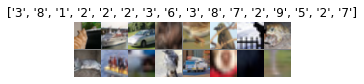

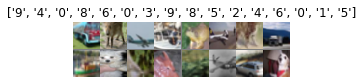

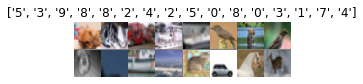

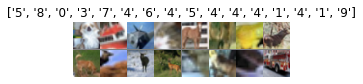

In [15]:
for i in range(4):
  batch(trainloader)

In [0]:
from torchvision import models

In [18]:
inception = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [0]:
for param in inception.parameters():
  param.requires_grad = False

In [0]:
aux_in_features = inception.AuxLogits.fc.in_features
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes)

In [0]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [0]:
new_transform = transforms.Compose([
                                transforms.RandomResizedCrop(299),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [23]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True,
                                        transform = new_transform)
testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                        download = True,
                                        transform = new_transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
device = torch.device('cuda:0')

In [0]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr = 0.5)

In [0]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs, _ = model(inputs)
    _, pred = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return (correct/total)*100

Min loss 7.65
Iteration: 0/3125, Loss: 7.65
Min loss 7.51
Min loss 5.71
Iteration: 100/3125, Loss: 22.54
Min loss 5.26
Iteration: 200/3125, Loss: 27.26
Min loss 4.39
Iteration: 300/3125, Loss: 16.60
Iteration: 400/3125, Loss: 7.35
Min loss 3.70
Iteration: 500/3125, Loss: 23.33
Iteration: 600/3125, Loss: 14.77
Iteration: 700/3125, Loss: 21.64
Iteration: 800/3125, Loss: 14.19
Iteration: 900/3125, Loss: 16.37
Iteration: 1000/3125, Loss: 21.51
Iteration: 1100/3125, Loss: 19.75
Iteration: 1200/3125, Loss: 18.61
Iteration: 1300/3125, Loss: 16.98
Iteration: 1400/3125, Loss: 14.07
Iteration: 1500/3125, Loss: 16.76
Iteration: 1600/3125, Loss: 17.43
Iteration: 1700/3125, Loss: 24.65
Iteration: 1800/3125, Loss: 18.25
Iteration: 1900/3125, Loss: 13.12
Iteration: 2000/3125, Loss: 14.08
Iteration: 2100/3125, Loss: 10.20
Iteration: 2200/3125, Loss: 15.24
Iteration: 2300/3125, Loss: 17.15
Iteration: 2400/3125, Loss: 9.17
Iteration: 2500/3125, Loss: 21.76
Iteration: 2600/3125, Loss: 9.31
Iteration: 270

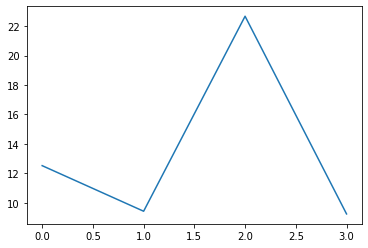

In [33]:
loss_epoch_ar = []
loss_batch = []
max_epochs = 4

min_loss = 10000000

n_iters = np.ceil(50000/batch_size)

for epoch in range(max_epochs):
  for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    outputs, aux_outputs = inception(inputs)
    loss = loss_fn(outputs, labels) + 0.3* loss_fn(aux_outputs, labels)
    loss.backward()
    opt.step()

    if min_loss>loss.item():
      min_loss = loss.item()
      best_model = copy.deepcopy(inception.state_dict())
      print('Min loss %0.2f' % min_loss)
    
    if i%100 is 0:
      loss_batch.append(loss.item())
      print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))

    del inputs, labels, outputs
    torch.cuda.empty_cache()
  
  loss_epoch_ar.append(loss.item())

  print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
        epoch, max_epochs, 
        evaluation(testloader, inception), 
        evaluation(trainloader, inception)))

plt.plot(loss_epoch_ar)
plt.show()

In [35]:
inception.load_state_dict(best_model)
print("Train Acc: ", evaluation(trainloader, inception))
print("Test Acc: ",  evaluation(testloader, inception))

Train Acc:  36.436
Test Acc:  36.51


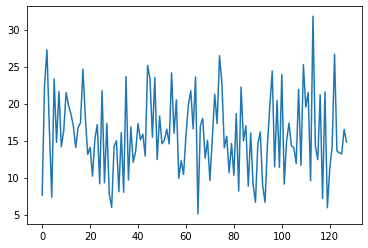

In [36]:
plt.plot(loss_batch)

In [0]:
torch.save(inception.state_dict(), "MyFirstInceptionNet.h5")